In [50]:
from abc import abstractmethod, abstractstaticmethod
from typing import Tuple
import numpy as np

from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn import datasets
import hw1

import torch
from catalyst import utils
from torch.utils.data import TensorDataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(2, 1, bias=False)

  def forward(self, x):
    y_hat = self.linear(x)
    return torch.sigmoid(y_hat)


In [16]:
eta = 0.1

model = LogisticRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=eta)
criterion = torch.nn.BCELoss()


In [17]:
def plot_history(x_torch, y_torch,n_samples,n_iter,batch_size,eta,optimizer,model,criterion):
  #all_loss = []
  history =[]
  for epoch in range(n_iter):
    permutation = torch.randperm(n_samples)

    epoch_loss = 0

    for batch_start in range(0, n_samples, batch_size):

        idx = permutation[batch_start:batch_start + batch_size]
        Xbatch = x_torch[idx, :]
        Ybatch = y_torch[idx, :]
    
        Ypred = model(Xbatch)
        
        loss_batch = criterion(Ypred, Ybatch)
        epoch_loss += loss_batch.item()
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        
    history.append(epoch_loss)

    plt.plot(history);
  

   # loss = criterion(y_hat, y_torch)
   # all_loss.append (loss.item())
   # loss.backward()

   # optimizer.step()
   # optimizer.zero_grad()

   # plt.plot(all_loss)

In [18]:
N_samples=10000

In [19]:
n_iter = 50
batch_size = 10
eta = 0.1

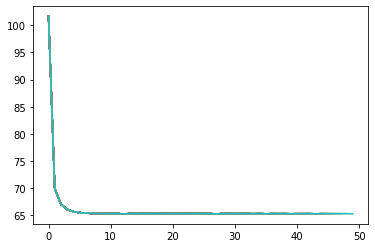

In [20]:
Xtrain_classification, Xtest_classification, Ytrain_classification, Ytest_classification=hw1.Make_classification(N_samples).data_split()

x_torch_classification_train = torch.tensor(Xtrain_classification, dtype=torch.float)
y_torch_classification_train = torch.tensor(Ytrain_classification, dtype=torch.float).reshape(-1, 1)
x_torch_classification_test = torch.tensor(Xtest_classification, dtype=torch.float)
y_torch_classification_test = torch.tensor(Ytest_classification, dtype=torch.float).reshape(-1, 1)

train_dataset = TensorDataset(x_torch_classification_train, y_torch_classification_train)
val_dataset = TensorDataset(x_torch_classification_test, y_torch_classification_test)
train_dataloadern = DataLoader(train_dataset_classification, batch_size=128)
val_dataloader = DataLoader(val_dataset_classification, batch_size=128)


n_samples_classification, n_features_classification = x_torch_classification.shape
plot_history(x_torch_classification, y_torch_classification,n_samples_classification,n_iter=n_iter,batch_size=batch_size,eta=eta,optimizer=optimizer,model=model,criterion=criterion)

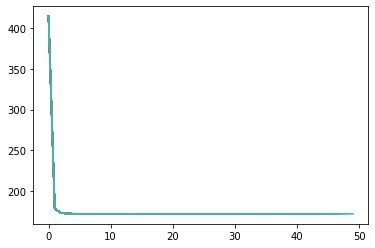

In [22]:
Xtrain_moons, Xtest_moons, Ytrain_moons, Ytest_moons=hw1.Make_moons(N_samples).data_split()

x_torch_moons = torch.tensor(Xtrain_moons, dtype=torch.float)
y_torch_moons = torch.tensor(Ytrain_moons, dtype=torch.float).reshape(-1, 1)

n_samples_moons, n_features_moons = x_torch_moons.shape
plot_history(x_torch_moons, y_torch_moons,n_samples_moons,n_iter=n_iter,batch_size=batch_size,eta=eta,optimizer=optimizer,model=model,criterion=criterion)

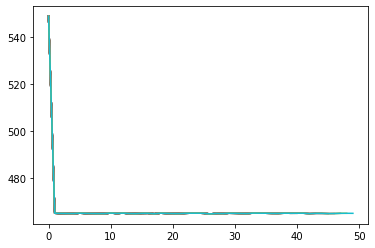

In [23]:
Xtrain_circles, Xtest_circles, Ytrain_circles, Ytest_circles=hw1.Make_circles(N_samples).data_split()

x_torch_circles = torch.tensor(Xtrain_circles, dtype=torch.float)
y_torch_circles = torch.tensor(Ytrain_circles, dtype=torch.float).reshape(-1, 1)

n_samples_circles, n_features_circles = x_torch_circles.shape
plot_history(x_torch_circles, y_torch_circles,n_samples_circles,n_iter=n_iter,batch_size=batch_size,eta=eta,optimizer=optimizer,model=model,criterion=criterion)

# Problem c

In [67]:
def train(model, epochs):
    losses = []
    max_epochs = epochs
    stop_it = False
    for epoch in range(max_epochs):
        utils.set_global_seed(42 + epoch)
        for it, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outp = model(X_batch)
            loss = loss_function(outp.flatten(), y_batch)
            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()
            probabilities = torch.sigmoid(outp)
            preds = (probabilities>0.5).type(torch.long)
    return model, losses

In [68]:
def show_loss(losses):
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

In [69]:
def show_separation(model, save=False, name_to_save=""):
    sns.set(style="white")

    xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    batch = torch.from_numpy(grid).type(torch.float32)
    with torch.no_grad():
        probs = torch.sigmoid(model(batch).reshape(xx.shape))
        probs = probs.numpy().reshape(xx.shape)

    f, ax = plt.subplots(figsize=(16, 10))
    ax.set_title("Decision boundary", fontsize=14)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    if save:
        plt.savefig(name_to_save)
    else:
        plt.show()

In [70]:
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [88]:
model_moon = torch.nn.Sequential(
    torch.nn.Linear(2, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_moon.parameters(), lr=0.05)

In [91]:
X, y = make_moons(10000, noise=0.05)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=33)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

#X, y = make_moons(n_samples=10000, random_state=42, noise=0.07)

model_moon, losses = train(model_moon, 100)

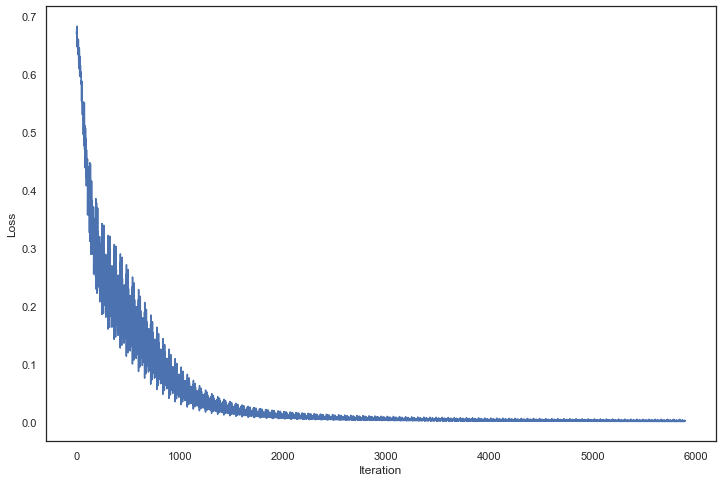

In [92]:
show_loss(losses)

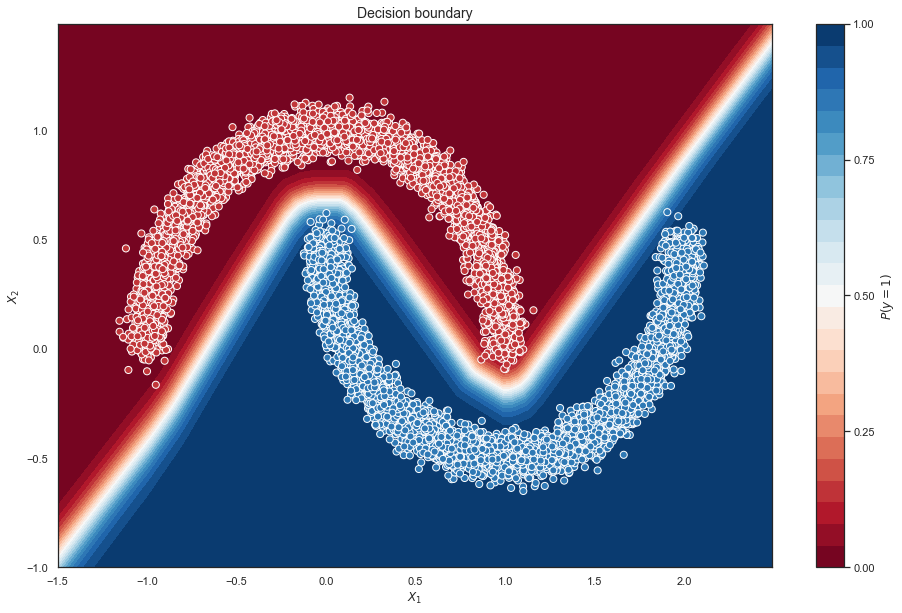

In [93]:
show_separation(model_moon)

In [125]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict(val_dataloader, model_moon))
print('%.9f' % accuracy)

0.0516000000


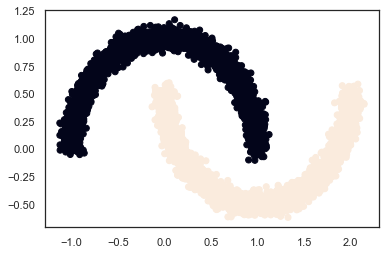

In [85]:
plt.scatter(x_torch_moons[:, 0], x_torch_moons[:, 1], marker='o', c=y_torch_moons)
plt.show()

In [100]:
X, y = make_circles(n_samples=10000, factor=0.5, noise=0.05)

In [113]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=33)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [114]:
model_circle = torch.nn.Sequential(
    torch.nn.Linear(2, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_circle.parameters(), lr=0.05)

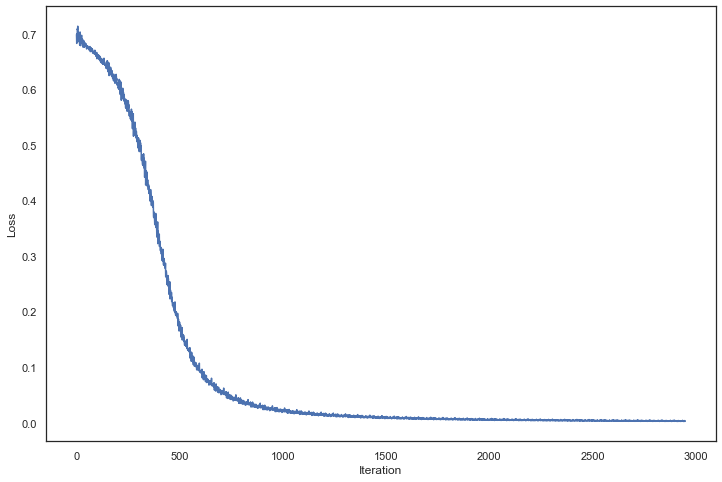

In [115]:
model_circle, losses = train(model_circle, 50)
show_loss(losses)

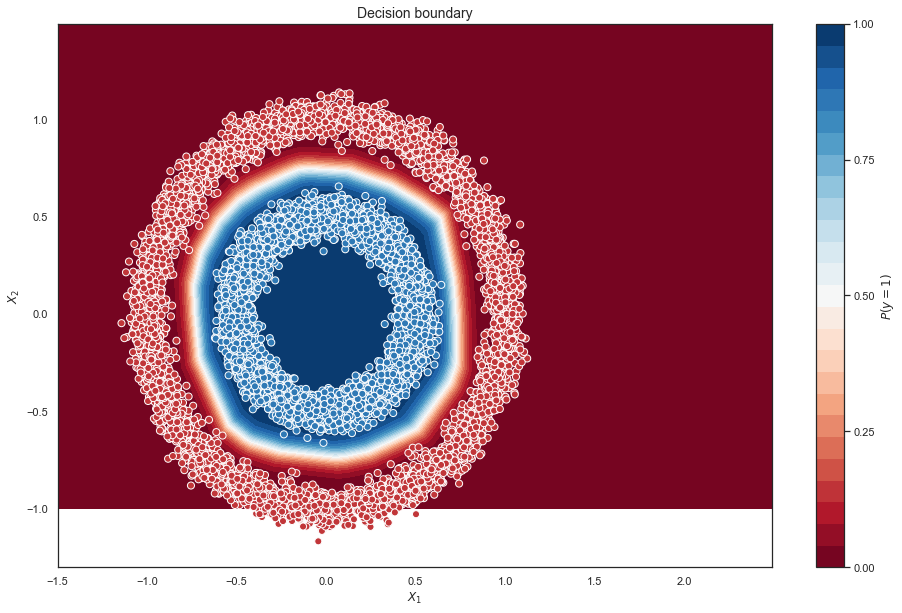

In [117]:
show_separation(model_circle)

In [112]:
accuracy = accuracy_score(y_val, predict(val_dataloader, model_circle))
accuracy

1.0

In [119]:
X, y =make_classification(10000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

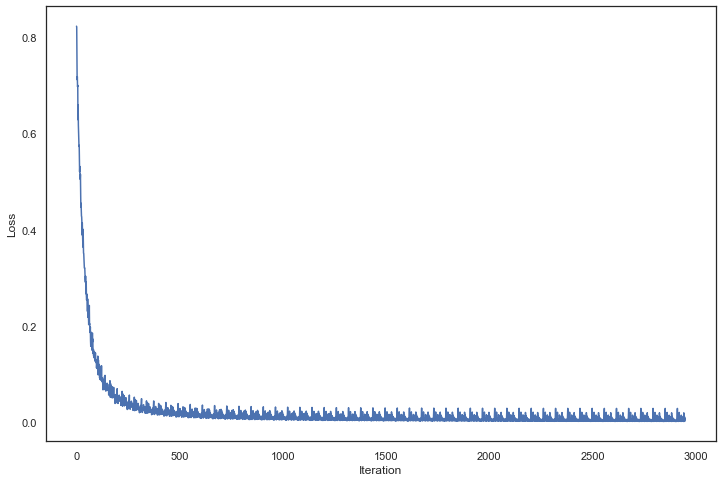

In [121]:
model_classification = torch.nn.Sequential(
    torch.nn.Linear(2, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_classification.parameters(), lr=0.05)

model_classification, losses = train(model_classification, 50)
show_loss(losses)

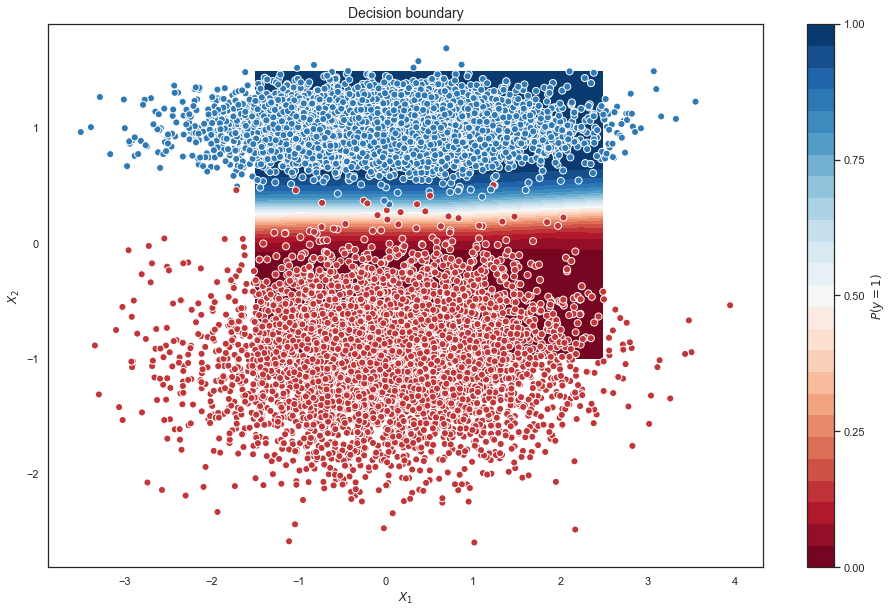

In [122]:
show_separation(model_classification)

In [124]:
accuracy = accuracy_score(y_val, predict(val_dataloader, model_classification))
accuracy

0.9972